In [9]:
import torch

In [10]:
import pandas as pd

In [11]:
import langdetect
from langdetect import DetectorFactory, detect, detect_langs

In [4]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [12]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

In [13]:
from langchain.embeddings import HuggingFaceEmbeddings

In [14]:
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

In [15]:
import myloadlib
from myloadlib import loadDir, loadFile, loadWiki, loadYoutube, readAPI

In [16]:
import importlib
importlib.reload(myloadlib)

<module 'myloadlib' from 'C:\\Users\\andre\\Software udvikling\\AI_exam\\generative AI\\myloadlib.py'>

In [62]:
documents = []

# Loading PDF

In [63]:
file = "./Rapport om Hussalg.pdf"

In [64]:
docs = loadFile(file)

In [65]:
documents.extend(docs)

In [66]:
len(documents)

2

In [67]:
documents[1].page_content[:300]

'Risiko for indbrud : \n[Indsæt kategorien for risiko for indbrud ] \nKontaktoplysninger  \nEjendomsmægler:  \n[Indsæt navn på ejendomsmægler]  \nTelefonnummer:  \n[Indsæt telefonnummer]  \nEmail:  \n[Indsæt emailadresse]  '

# Transforming text to prepare if for AI processing.

In [68]:
import myutils
from myutils import chunkDocs, langDetect, wordCloud 

In [69]:
importlib.reload(myutils)

<module 'myutils' from 'C:\\Users\\andre\\Software udvikling\\AI_exam\\generative AI\\myutils.py'>

In [72]:
splits = myutils.chunkDocs(documents, 100)  
splits

[Document(page_content='Rapport om Hussalg  \nEjendomsoplysninger  \nAdresse:  \n[Indsæt adresse]  \nPostnummer og By:', metadata={'source': './Rapport om Hussalg.pdf', 'page': 0}),
 Document(page_content='[Indsæt postnummer og by]  \nBoligtype:  \n[Indsæt boligtype, fx villa, rækkehus, lejlighed]', metadata={'source': './Rapport om Hussalg.pdf', 'page': 0}),
 Document(page_content='Byggeår:  \n[Indsæt byggeår]  \nBoligareal:  \n[Indsæt boligareal i kvadratmeter]  \nAntal værelser:', metadata={'source': './Rapport om Hussalg.pdf', 'page': 0}),
 Document(page_content='[Indsæt antal værelser]  \nBeliggenhed  \nNærmeste Apotek : \n[Indsæt afstand  til nærmest e apote k]', metadata={'source': './Rapport om Hussalg.pdf', 'page': 0}),
 Document(page_content='Nærmeste Børnehave : \n[Indsæt afstand  til nærmest e apote k] \nNærmeste Indkøbsbutik :', metadata={'source': './Rapport om Hussalg.pdf', 'page': 0}),
 Document(page_content='[Indsæt afstand  til nærmest e apote k] \nØkonomiske Oplysnin

In [73]:
len(splits)

11

In [74]:
splits[8]

Document(page_content='Risiko for indbrud : \n[Indsæt kategorien for risiko for indbrud ] \nKontaktoplysninger', metadata={'source': './Rapport om Hussalg.pdf', 'page': 1})

In [75]:
df = pd.DataFrame(splits, columns=['page_content', 'metadata', 'type'])
df.sample(5)

,page_content,metadata,type
5,"(page_content, [Indsæt afstand til nærmest e ...","(metadata, {'source': './Rapport om Hussalg.pd...","(type, Document)"
1,"(page_content, [Indsæt postnummer og by] \nBo...","(metadata, {'source': './Rapport om Hussalg.pd...","(type, Document)"
9,"(page_content, Ejendomsmægler: \n[Indsæt navn...","(metadata, {'source': './Rapport om Hussalg.pd...","(type, Document)"
7,"(page_content, [Indsæt ejendommens energimærke])","(metadata, {'source': './Rapport om Hussalg.pd...","(type, Document)"
8,"(page_content, Risiko for indbrud : \n[Indsæt ...","(metadata, {'source': './Rapport om Hussalg.pd...","(type, Document)"


In [76]:
df['page_content'][0]

('page_content',
 'Rapport om Hussalg  \nEjendomsoplysninger  \nAdresse:  \n[Indsæt adresse]  \nPostnummer og By:')

In [77]:
df['metadata'][0]

('metadata', {'source': './Rapport om Hussalg.pdf', 'page': 0})

In [78]:
im, longstring = myutils.wordCloud(df, 'page_content')

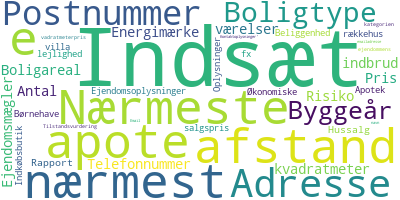

In [79]:
im

# Store documents in vector database

In [80]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

In [81]:
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

C:\Users\andre\anaconda3\envs\ai_exam\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [82]:
persist_directory = '../data/chroma/'

vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)
vectordb.persist()

In [83]:
vectordb._collection.count()

50

In [84]:
query = 'Lav et dokument for et hus 1000 kroner værd'

In [85]:
answer = vectordb.similarity_search(query, k=3)
answer

[Document(page_content='[Indsæt oplysninger om indkøbsmuligheder i området]', metadata={'page': 0, 'source': './Rapport om Hussalg.pdf'}),
 Document(page_content='[Indsæt afstand  til nærmest e apote k] \nØkonomiske Oplysninger  \nPris:  \n[Indsæt salgspris]', metadata={'page': 0, 'source': './Rapport om Hussalg.pdf'}),
 Document(page_content='[Indsæt antal badeværelser]  \nBeskrivelse af Ejendommen  \n[Indsæt detaljeret beskrivelse af ejendommen, fx indretning, materialer, særlige kendetegn, \nrenoveringer osv.]  \nBeliggenhed', metadata={'page': 0, 'source': './Rapport om Hussalg.pdf'})]

In [86]:
for d in answer:
    print(d.page_content)

[Indsæt oplysninger om indkøbsmuligheder i området]
[Indsæt afstand  til nærmest e apote k] 
Økonomiske Oplysninger  
Pris:  
[Indsæt salgspris]
[Indsæt antal badeværelser]  
Beskrivelse af Ejendommen  
[Indsæt detaljeret beskrivelse af ejendommen, fx indretning, materialer, særlige kendetegn, 
renoveringer osv.]  
Beliggenhed


In [87]:
from langchain.llms import Ollama
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

In [107]:
!ollama list

NAME          	ID          	SIZE  	MODIFIED    
mistral:latest	2ae6f6dd7a3d	4.1 GB	12 days ago	


In [108]:
llm = Ollama(model="mistral", callback_manager = CallbackManager([StreamingStdOutCallbackHandler()]))

In [195]:
# Skal bruge input fra GUI når den er klar i stedet for dette
house_info = {"adresse": "Nygårdsvej 41A. 2. tv", 
              "postnummer": "3460",
             "by": "Birkerød",
             "pris": 3895000,
             "type": "Ejerlejlighed",
             "antal_værelser": 3,
             "byggeår": 1969,
             "indbrud": "lav",
             "apotek": 480,
             "børnehave": 141,
             "indkøbsbutik": 78,
             "størrelse": 76,
             "kvadratmeterpris": 51250,
             "energimærke": "C",
             }
agent_info = {"navn": "Adam Sælger",
              "tlfnr": 33553355,
              "email": "as@gmail.com"
             }

In [194]:
def generate_template(house_info, agent_info):
    template = f"""Lav en rapport med disse oplysninger i samme format, men med overskrifter, der giver mening.
    Adressen: {house_info["adresse"]}
    Postnummer: {house_info["postnummer"]}
    By: {house_info["by"]}
    Pris: {house_info["pris"]} kroner
    Type: {house_info["type"]}
    Antal værelser: {house_info["antal_værelser"]}
    Byggeår: {house_info["byggeår"]}
    Risiko for indbrud: {house_info["indbrud"]} meter
    Afstand til apotek: {house_info["apotek"]} meter
    Afstand til børnehave: {house_info["børnehave"]} meter
    Afstand til indkøbsbutik: {house_info["indkøbsbutik"]} meter
    Størrelse: {house_info["størrelse"]} m^2
    Kvadratmeterpris: {house_info["kvadratmeterpris"]} kroner
    Energimærke: {house_info["energimærke"]}
    Ejendomsmægler oplysninger: {agent_info["navn"]}, 
    Telefonnummer: {agent_info["tlfnr"]}, 
    Email: {agent_info["email"]}
    """
    final_template = template + """{context}"""
    return final_template

In [189]:
prompt = PromptTemplate.from_template(generate_template(house_info, agent_info))
chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt})

In [190]:
query = "Giv mig min fulde rapport"

In [191]:
result = chain({"query": query})
result["result"]

 Rapport om Hussalg

Ejendomsoplysninger
-------------------

Adresse: Nygårdsvej 41A. 2. tv

Postnummer og By: 3460 Birkerød

Boligtype: Ejerlejlighed

Byggeår: 1969

Rapport om Hussalg
------------------

* Adresse: Nygårdsvej 41A. 2. tv, 3460 Birkerød
* Boligtype: Ejerlejlighed
* Byggeår: 1969

Ejendomsmægler oplysninger
---------------------------

* Adam Sælger
* Telefonnummer: 33553355
* Email: as@gmail.com

Bilag
-----

* Tilstandsrapport
* Energimærke (C)
* Plantegninger

Ejendomsoplysninger
-------------------

* Adresse: [Indsæt adresse]
* Postnummer og By: [Indsæt postnummer og by]
* Boligtype: [Indsæt boligtype, fx villa, rækkehus, lejlighed]
* Byggeår: [Indsæt byggeår]
* Bilag (eventuelle bilag, fx tilstandsrapport, energimærke, plantegninger)

Ejerlejlighed på Nygårdsvej 41A. 2. tv i Birkerød med 3 værelser og et areal på 76 m² priser sig til 3.895.000 kroner. Det er bygget i 1969, og der er lavt risiko for indbrud. Den er placeret ved siden af apoteket (480 meter), børne

' Rapport om Hussalg\n=======================\n\nEjendomsoplysninger\n-------------------\n\nAdresse: Nygårdsvej 41A. 2. tv\n\nPostnummer og By: 3460 Birkerød\n\nBoligtype: Ejerlejlighed\n\nByggeår: 1969\n\nRapport om Hussalg\n------------------\n\n* Adresse: Nygårdsvej 41A. 2. tv, 3460 Birkerød\n* Boligtype: Ejerlejlighed\n* Byggeår: 1969\n\nEjendomsmægler oplysninger\n---------------------------\n\n* Adam Sælger\n* Telefonnummer: 33553355\n* Email: as@gmail.com\n\nBilag\n-----\n\n* Tilstandsrapport\n* Energimærke (C)\n* Plantegninger\n\nEjendomsoplysninger\n-------------------\n\n* Adresse: [Indsæt adresse]\n* Postnummer og By: [Indsæt postnummer og by]\n* Boligtype: [Indsæt boligtype, fx villa, rækkehus, lejlighed]\n* Byggeår: [Indsæt byggeår]\n* Bilag (eventuelle bilag, fx tilstandsrapport, energimærke, plantegninger)\n\nEjerlejlighed på Nygårdsvej 41A. 2. tv i Birkerød med 3 værelser og et areal på 76 m² priser sig til 3.895.000 kroner. Det er bygget i 1969, og der er lavt risiko 

In [166]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

def create_pdf(content, filename):
    c = canvas.Canvas(filename, pagesize=letter)
    textobject = c.beginText(100, 750)

    for line in content.split('\n'):
        textobject.textLine(line)

    c.drawText(textobject)
    c.save()

In [167]:
create_pdf(result["result"], "hus_report.pdf")